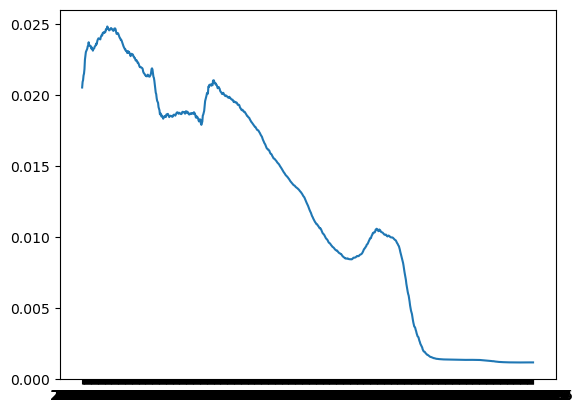

[1. 감염률 데이터 분석]
[감염률 정규성 검증]
Shapiro Test-statistics : 0.853910505771637, p-value : 7.790196369742615e-21
Shapiro Test-statistics : 0.8355441093444824, p-value : 7.482938964645247e-13
Shapiro Test-statistics : 0.8051779270172119, p-value : 7.124987931638157e-19

[감염률 등분산 검증]
Fligner Test-statistics : 683.7901745808464, p-value : 3.2873822050209747e-149

[감염률 Kruskal-Wallis Test]
Kruskal-Wallis Test-statistics : 804.3463264524516, p-value : 2.1797889228493447e-175

[2. 치명률 데이터 분석]
[치명률 정규성 검증]
Shapiro Test-statistics : 0.9608438611030579, p-value : 4.450548818368816e-10
Shapiro Test-statistics : 0.9434989094734192, p-value : 1.8119402511729277e-06
Shapiro Test-statistics : 0.5536780953407288, p-value : 3.1924320684309763e-27

[치명률 등분산 검증]
Fligner Test-statistics : 148.9384212608489, p-value : 4.554416576790575e-33
[치명률 Kruskal-Wallis Test]
Kruskal-Wallis Test-statistics : 798.2136625406547, p-value : 4.678487671713772e-174



In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
from decimal import Decimal

#by_60211642
data = pd.read_csv("./코로나바이러스감염증-19_확진환자_발생현황_221126.csv", header = 0)
data.tail(10)

df_covid = data.loc[:,['일자','계(명)','사망(명)']][:1042]
df_covid3 = data.loc[:,['일자','계(명)','사망(명)']][57:1042]
df_accumulate = data.loc[:,['일자','계(명)','사망(명)']][1042:1043] 

df_covid.isna().sum()

df_covid = df_covid.replace("-", 0).set_index('일자')

#누적 확진자 수 구하는 코드
df_covid["누적 확진자 수"] = df_covid["계(명)"]
def cumulative_number(i):
    if i == 0:
        df_covid["누적 확진자 수"][0] = int(df_covid["계(명)"][0])
    else:
        if type(df_covid["계(명)"][i]) != int :
            p = df_covid["계(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_covid["계(명)"][i] = int(str_confirmed)
            
        df_covid["누적 확진자 수"][i] = int(df_covid["누적 확진자 수"][i-1]) + df_covid["계(명)"][i]

for i in range(len(df_covid)):
    cumulative_number(i)
    
#누적 사망자 수 구하는 코드
df_covid["누적 사망자 수"] = df_covid["계(명)"]
def cumulative_number2(i):
    if i == 0:
        df_covid["누적 사망자 수"][0] = int(df_covid["사망(명)"][0])
    else:
        if type(df_covid["사망(명)"][i]) != int :
            p = df_covid["사망(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_covid["사망(명)"][i] = int(str_confirmed)
            
        df_covid["누적 사망자 수"][i] = int(df_covid["누적 사망자 수"][i-1]) + df_covid["사망(명)"][i]

for i in range(len(df_covid)):
    cumulative_number2(i)

#감염률 구하는 코드
df_covid["감염률"] = df_covid["계(명)"]
def infection_rate(i):
    rok_pop = 51628117
    if i == 0:
        df_covid["감염률"][0] = int(df_covid["계(명)"][0])/rok_pop
    else:
        #분모 (전체 국민 - 당일의 누적 확진자 수)
        denominator = (rok_pop - df_covid["누적 확진자 수"][i-1])
        #분자 (당일의 확진자 수)
        numerator = df_covid["계(명)"][i]
        p_infection = numerator/denominator
        df_covid["감염률"][i] = p_infection
            
    
for i in range(len(df_covid)):
    infection_rate(i)

#치명률 구하는 코드
df_covid["치명률"] = df_covid["누적 사망자 수"]
def death_rate(i):
    if i <17:
        #이러면 초기 17일 치명률은 또 outlier 처리 필요함. (by60211642) -> 왜? : 치명률이 이미 들어간 상태로 결과 값이 나와 있는데 
        # 이전의 치명률이기 때문에 잘라야함.
        df_covid["치명률"][0] = 0
    else:
        #분자 (누적 사망자 수)
        #분모 (17일 전 누적 확진자 수)
        p_lethality = int(df_covid["누적 사망자 수"][i])/int(df_covid["누적 확진자 수"][i-17])
        df_covid["치명률"][i] = p_lethality
            
    
for i in range(len(df_covid)):
    death_rate(i)

#column 이름 명확하게 바꿈 (by60211642)
df_covid.rename(columns = {'계(명)':'일일 확진자 수'}, inplace=True)
df_covid.rename(columns = {'사망(명)':'일일 사망자 수'}, inplace=True)

# 신천지 집단 감염 사태와 코로나 유행 초기인 걸 생각했을 때 앞부분 데이터가 신뢰도가 떨어질 것.
# 신천지 사태 한 달 후인 3월 17일 이후 데이터만 사용하는게 치명률에서 이상치를 줄일 수 있을 것이라 생각.
# 이름이 의미를 가지게 수정(by60211642)
df_covid_rmOutlier = df_covid.loc['2020.3.17':]

# df_covid_rmOutlier.head(50)

# #치명률 그래프로 확인
plt.plot(df_covid3['일자'][16:], df_covid_rmOutlier['치명률'][16:])
plt.show()

#우세종에 따른 데이터 구간 나누기 -> 기타, delta, omi 이렇게 3가지로 나눴음. 결국은 초기 치명률은 outlier
#: 우리가 본 data에서는 신천지 집단 감염 때문에 나왔기 때문에 제거 필요. (by 60211642) -> 우리 data에서는 유의미하게 값이 달라지지는 않음
df_covid_etc = df_covid_rmOutlier.loc['2020.4.2':"2021.7.31"]
df_covid_delta = df_covid_rmOutlier.loc["2021.8.1":"2022.1.24"]
df_covid_omi = df_covid_rmOutlier.loc["2022.1.25":]

#1 감염률 데이터 분석 
print("[1. 감염률 데이터 분석]")
#타입변환
df_covid_etc = df_covid_etc.astype({'감염률' : 'float'})
df_covid_delta = df_covid_delta.astype({'감염률' : 'float'})
df_covid_omi = df_covid_omi.astype({'감염률' : 'float'})

#정규성 검증
print("[감염률 정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

print("[감염률 등분산 검증]")
# 정규분포 아닐 시 bartlett사용 불가 -> non-parametric method인 fligner test 사용(by 60211642)
test_stat, p_val = stats.fligner(df_covid_etc["감염률"],df_covid_delta["감염률"],df_covid_omi["감염률"])
print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()


#정규성을 만족하지 않으므로 Kruskal-Wallis Test 실행
#ks test
print("[감염률 Kruskal-Wallis Test]")
test_stat, p_val = stats.kruskal(df_covid_etc["감염률"], df_covid_delta["감염률"], df_covid_omi["감염률"])
print("Kruskal-Wallis Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

#2 치명률 데이터 분석 
print("[2. 치명률 데이터 분석]")
#타입변환
df_covid_etc = df_covid_etc.astype({'치명률' : 'float'})
df_covid_delta = df_covid_delta.astype({'치명률' : 'float'})
df_covid_omi = df_covid_omi.astype({'치명률' : 'float'})

#정규성 검증
print("[치명률 정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

#등분산 검증
print("[치명률 등분산 검증]")
# 정규분포 아닐 시 bartlett사용 불가 -> non-parametric method인 fligner test 사용(by 60211642)
test_stat, p_val = stats.fligner(df_covid_etc["치명률"],df_covid_delta["치명률"],df_covid_omi["치명률"])
print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))

#정규성을 만족하지 않으므로 Kruskal-Wallis Test 실행
#ks test
print("[치명률 Kruskal-Wallis Test]")
test_stat, p_val = stats.kruskal(df_covid_etc["치명률"], df_covid_delta["치명률"], df_covid_omi["치명률"])
print("Kruskal-Wallis Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()